## Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/projects/covid_networks

Mounted at /content/gdrive
/content/gdrive/My Drive/projects/covid_networks


## setup and Loading

In [2]:
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import math
import networkx as nx
from sklearn.linear_model import LinearRegression
import sklearn as sc
import plotly.graph_objects as go
import utils as util
import random
import joblib
import statsmodels.api as sm
import plotly.express as px
import os
from collections import defaultdict

%matplotlib inline
plt.style.use('seaborn-white')
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
import utils as util
g = util.read_network("artifacts/H_sapiens.net")
interactions = util.load_and_map_interactions()
W, num_genes, gene_indexes, gene_scores = util.load_network_scores(g)
random_networks = util.load_random_networks(g, interactions)

# grouping count
ongoing_data = interactions.groupby("viral", as_index=False).count()[['viral', 'Preys']]
ongoing_data["viral"] = ongoing_data.apply(lambda row: row["viral"].lower(), axis=1)
# ongoing_data.to_csv(ongoing_data_path, index=False)
# all target protiens
all_targets = util.load_all_targets()

querying 1-332...done.
Finished.
loading propagated network from disk
loading random networks from disk


## Networks Loading

### Propagate Real

In [ ]:
# Loading Datasets
g = util.read_network("artifacts/H_sapiens.net")
# https://www.nature.com/articles/s41586-020-2286-9#Sec36
interactions = pd.read_csv("covid_files/data/inputs/interactions.csv")

# %%
# propogate Network for all Genes
network_path = f"artifacts/network_scores.pkl.gz"

if os.path.exists(network_path):
    print('loading propagated network from disk')
    network_scores = joblib.load(network_path)
    W, num_genes, gene_indexes, gene_scores = (
        network_scores["W"],
        network_scores["num_genes"],
        network_scores["gene_indexes"],
        network_scores["gene_scores"],
    )
else:
    print('start propagating network')
    W, num_genes, gene_indexes, gene_scores = util.generate_propagate_data(g)
    network_scores = {"W": W, "num_genes": num_genes, "gene_indexes": gene_indexes, "gene_scores": gene_scores}
    joblib.dump(network_scores, network_path)


loading propagated network from disk


In [ ]:
interactions = pd.read_csv("covid_files/data/inputs/interactions.csv")
xli = interactions["PreyGene"].unique().tolist()
out = pd.DataFrame(mg.querymany(xli, scopes="symbol", fields="entrezgene", species="human"))
interactions = pd.merge(interactions, out[["query", "entrezgene"]], left_on="PreyGene", right_on="query")
interactions["entrezgene"] = interactions["entrezgene"].astype(int)
# grouping count
ongoing_data = interactions.groupby("viral", as_index=False).count()[['viral', 'Preys']]
ongoing_data["viral"] = ongoing_data.apply(lambda row: row["viral"].lower(), axis=1)

NameError: ignored

### Propagate Random

In [ ]:
random_networks_path = f"artifacts/random_networks_score.pkl.gz"
E = g.number_of_edges()
Q = 10
inter_genes = list(interactions["entrezgene"].unique())
random_networks = {}
if os.path.exists(random_networks_path):
  print('loading random networks from disk')
  random_networks = joblib.load(random_networks_path)
else:
  for i in range(100):
      H = g.copy()
      nx.swap.double_edge_swap(H, nswap=Q*E, max_tries=Q*E*2)
      W_temp, num_genes_temp, gene_indexes_temp, gene_scores_temp = util.generate_propagate_data(H, inter_genes)
      random_networks[i] = gene_scores_temp
      print(f"network {i} generated")
  random_networks_path = f"artifacts/random_networks_score.pkl.gz"
  joblib.dump(random_networks, random_networks_path)

## Data Loading/Mapping

## 2 proportions of scores

In [ ]:
# calculate prob 
proportions = ongoing_data.copy()
for dataset, target in all_targets.items():
  entrez = list(target.values())
  entrez_index = []
  runs = []
  for index, row in ongoing_data.iterrows():
      # calculate the score of viral gene
      sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
      for id in entrez:
        if gene_indexes.get(id):
          entrez_index.append(gene_indexes[id])
      score = sum(sum(gene_scores[s][entrez_index]) for s in sources)
      runs.append(score/len(sources))
      # runs.append(score)
  proportions[dataset] = runs/sum(runs)
proportions.to_csv('covid_files/2_proportions_of_scores/2.1_proportions.csv', index=False)

In [ ]:
proportions = pd.read_csv('covid_files/2_proportions_of_scores/2.1_proportions.csv')
# heatmap of effects
viral_protiens = proportions["viral"].tolist()
cells = proportions.columns.to_list()[2:]
effects = proportions[[i for i in cells]].to_numpy()
trace = go.Heatmap(x=cells, y=viral_protiens, z=effects, type="heatmap", colorscale="Viridis")
data = [trace]
fig = go.Figure(data=data)
fig.update_xaxes(side="top")
fig.update_layout(
    showlegend=False,
    width=1000,
    height=1200,
    autosize=True,
    xaxis_title="Cells",
    yaxis_title="Viral Protiens",)
fig.write_html("covid_files/2_proportions_of_scores/2.1_proportion.html")
fig.show()

## 3 Random Networks

all datasets sum random by network p-value is log pvalue

### 3.1 All datasets

In [ ]:
# calculate p-value
networks = ongoing_data.copy()
for dataset, target in all_targets.items():
  entrez = list(target.values())
  entrez_index = []
  viral_p_values = []

  for id in entrez:
    if gene_indexes.get(id):
      entrez_index.append(gene_indexes[id])

  for index, row in ongoing_data.iterrows():
      runs = []
      # calculate the score of viral gene
      sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
      score = sum(sum(gene_scores[s][entrez_index]) for s in sources)
      runs.append(score)

      # generate 100 random scores by 100 random networks
      for network_id, net_scores in random_networks.items():
        score = sum(sum(net_scores[s][entrez_index]) for s in sources)
        runs.append(score)

      pvalue = (102 - sp.stats.rankdata(runs, method="ordinal")[0]) / 101
      viral_p_values.append(pvalue)

  networks[dataset] = np.abs(np.log(viral_p_values)*(-1))
networks.to_csv('covid_files/3_random_networks/3.1_p_values.csv', index=False)

In [ ]:
# adding random dataset
networks = pd.read_csv('covid_files/3_random_networks/3.1_p_values.csv')
entrez_index = np.random.random_integers(0,len(gene_indexes), 5)
viral_p_values = []
for index, row in ongoing_data.iterrows():
      runs = []
      # calculate the score of viral gene
      sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
      score = sum(sum(gene_scores[s][entrez_index]) for s in sources)
      runs.append(score)

      # generate 100 random scores by 100 random networks
      for network_id, net_scores in random_networks.items():
        score = sum(sum(net_scores[s][entrez_index]) for s in sources)
        runs.append(score)

      pvalue = (102 - sp.stats.rankdata(runs, method="ordinal")[0]) / 101
      viral_p_values.append(pvalue)

networks['random'] = np.abs(np.log(viral_p_values)*(-1))
networks.to_csv('covid_files/3_random_networks/3.1_p_values.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

This function is deprecated. Please call randint(0, 18850 + 1) instead



In [ ]:
networks = pd.read_csv('covid_files/3_random_networks/3.1_p_values.csv')
# heatmap of effects
viral_protiens = networks["viral"].tolist()
cells = networks.columns.to_list()[2:]
effects = networks[[i for i in cells]].to_numpy()
trace = go.Heatmap(x=cells, y=viral_protiens, z=effects, type="heatmap", colorscale="Viridis")
data = [trace]
fig = go.Figure(data=data)
fig.update_xaxes(side="top")
fig.update_layout(
    showlegend=False,
    width=1000,
    height=1200,
    autosize=True,
    xaxis_title="Cells",
    yaxis_title="Viral Protiens",)
fig.write_html("covid_files/3_random_networks/3.1_p_values.html")
fig.show()

### 3.2 by Target

In [ ]:
# calculate p_value by target 
for dataset, target in all_targets.items():
  temp_data = ongoing_data.copy()
  for target_name, id in target.items():
    viral_p_values = []
    if gene_indexes.get(id):
      tar_id = gene_indexes[id]
      for index, row in ongoing_data.iterrows():
          runs = []
          # calculate the score of viral gene
          sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
          score = sum(gene_scores[s][tar_id] for s in sources)
          runs.append(score)

          # generate 100 random scores by 100 random networks
          for network_id, net_scores in random_networks.items():
            score = sum(net_scores[s][tar_id] for s in sources)
            runs.append(score)

          pvalue = (102 - sp.stats.rankdata(runs, method="ordinal")[0]) / 101
          viral_p_values.append(pvalue)

      temp_data[target_name] = viral_p_values
  temp_data.to_csv(f'covid_files/3_random_networks/3.2_{dataset}_p_values.csv', index=False)

In [ ]:
# heatmap of effects
for dataset, target in all_targets.items():
  temp_data = pd.read_csv(f'covid_files/3_random_networks/3.2_{dataset}_p_values.csv')
  viral_protiens = temp_data["viral"].tolist()
  cells = temp_data.columns.to_list()[2:]
  effects = temp_data[[i for i in cells]].to_numpy()
  trace = go.Heatmap(x=cells, y=viral_protiens, z=np.abs(np.log(effects)), type="heatmap", colorscale="Viridis")
  data = [trace]
  fig = go.Figure(data=data)
  fig.update_xaxes(side="top")
  fig.update_layout(
      showlegend=False,
      width=1000,
      height=1200,
      autosize=True,
      xaxis_title="Genes",
      yaxis_title="Viral Protiens",)
  fig.write_html(f"covid_files/3_random_networks/3.2_{dataset}_plot.html")
  # fig.show()

#### Raw Score

In [5]:
# calculate p_value by target 
for dataset, target in all_targets.items():
  temp_data = ongoing_data.copy()
  for target_name, id in target.items():
    runs = []
    if gene_indexes.get(id):
      tar_id = gene_indexes[id]
      for index, row in ongoing_data.iterrows():
          # calculate the score of viral gene
          sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
          score = sum(gene_scores[s][tar_id] for s in sources)
          runs.append(score)

      temp_data[target_name] = runs
  temp_data.to_csv(f'covid_files/3_random_networks/3.2_{dataset}_scores.csv', index=False)

In [6]:
# heatmap of effects
for dataset, target in all_targets.items():
  temp_data = pd.read_csv(f'covid_files/3_random_networks/3.2_{dataset}_scores.csv')
  viral_protiens = temp_data["viral"].tolist()
  cells = temp_data.columns.to_list()[2:]
  effects = temp_data[[i for i in cells]].to_numpy()
  trace = go.Heatmap(x=cells, y=viral_protiens, z=effects, type="heatmap", colorscale="Viridis")
  data = [trace]
  fig = go.Figure(data=data)
  fig.update_xaxes(side="top")
  fig.update_layout(
      showlegend=False,
      width=1000,
      height=1200,
      autosize=True,
      xaxis_title="Genes",
      yaxis_title="Viral Protiens",)
  fig.write_html(f"covid_files/3_random_networks/3.2_{dataset}_scores.html")
  # fig.show()

### ELIFE

In [ ]:
# calculate p_value by target
target = all_targets['vascular']
temp_data = ongoing_data.copy()
arr = np.zeros((len(temp_data),len(target),101))
j = 0
for target_name, id in target.items():
  viral_p_values = []
  if gene_indexes.get(id):
    tar_id = gene_indexes[id]
    i=0
    for index, row in ongoing_data.iterrows():
        runs = []
        # calculate the score of viral gene
        sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
        score = sum(gene_scores[s][tar_id] for s in sources)
        runs.append(score)

        # generate 100 random scores by 100 random networks
        for network_id, net_scores in random_networks.items():
          score = sum(net_scores[s][tar_id] for s in sources)
          runs.append(score)

        pvalue = (102 - sp.stats.rankdata(runs, method="ordinal")[0]) / 101
        viral_p_values.append(pvalue)
        arr[i,j,:] = runs
        i+=1
    j+=1
    # temp_data[target_name] = runs
    # temp_data[target_name] = np.abs(np.log(viral_p_values)*(-1))
    # temp_data[target_name] = viral_p_values + np.finfo(float).eps
# temp_data.to_csv(f'covid_files/ELIFE/scores.csv', index=False)

In [ ]:
target

{'Cadherin-2': 1000,
 'Cadherin-3': 1001,
 'Cadherin-4': 1002,
 'Cadherin-5': 1003,
 'Catenin delta 1': 1500,
 'Cateninβ ': 1499,
 'Claudin-5': 7122,
 'Occludin': 100506658,
 'ZO-1': 7082,
 'ZO-2': 9414,
 'ZO-3': 27134,
 'α Catenin ': 1495}

In [ ]:
cells = {'HPAEC': [0,3,4,5,6,7,8,9,11],
         'HUVEC': [0,1,2,3,4,5,6,7,8,9,10,11],
         'HUAEC': [1,3,4,5,6,7,8,9,10],
         'HGSVEC': [3,4,6,7,8,9,10,11],
         'HCCaEC': [0,2,5,6,7,8,9,10],
         'HAoEC': [5,6,7,8,9,10,11],
         'HCAEC': [2,3,4,5,6,7,8,9,10,11],
         'HENDC': [0,3,5,6,7,8,11],
         'HRAEC': [2,3,5,6,7,8],}

#### All raw scores


In [ ]:
temp_data = ongoing_data.copy()
for cell, targets in cells.items():
  temp_data[cell] = np.sum(arr[:,targets,0],1)
temp_data.to_csv(f'covid_files/ELIFE/all_cells_raw.csv', index=False)

In [ ]:
temp_data = pd.read_csv(f'covid_files/ELIFE/all_cells_raw.csv')
viral_protiens = temp_data["viral"].tolist()
cells = temp_data.columns.to_list()[2:]
effects = temp_data[[i for i in cells]].to_numpy()
trace = go.Heatmap(x=cells, y=viral_protiens, z=effects, type="heatmap", colorscale="Viridis")
data = [trace]
fig = go.Figure(data=data)
fig.update_xaxes(side="top")
fig.update_layout(
    showlegend=False,
    width=1000,
    height=1200,
    autosize=True,
    xaxis_title="Cells",
    yaxis_title="Viral Protiens",)
fig.write_html(f"covid_files/ELIFE/all_cells_raw_plot.html")
fig.show()

#### All p-value

In [ ]:
temp_data = ongoing_data.copy()
for cell, targets in cells.items():
  all_p = []
  for index, row in temp_data.iterrows():
    all_p.append((102 - sp.stats.rankdata(np.sum(arr[index,targets,:],0), method="ordinal")[0]) / 101)
  temp_data[cell] = all_p
temp_data.to_csv(f'covid_files/ELIFE/all_cells_p_value.csv', index=False)

In [ ]:
temp_data = pd.read_csv(f'covid_files/ELIFE/all_cells_p_value.csv')
viral_protiens = temp_data["viral"].tolist()
cells = temp_data.columns.to_list()[2:]
effects = temp_data[[i for i in cells]].to_numpy()
trace = go.Heatmap(x=cells, y=viral_protiens, z=np.abs(np.log(effects)), type="heatmap", colorscale="Viridis")
data = [trace]
fig = go.Figure(data=data)
fig.update_xaxes(side="top")
fig.update_layout(
    showlegend=False,
    width=1000,
    height=1200,
    autosize=True,
    xaxis_title="Cells",
    yaxis_title="Viral Protiens",)
fig.write_html(f"covid_files/ELIFE/all_cells_p_value.html")
fig.show()

In [ ]:
cells_scores

{'HAoEC': 0.2299163940508248,
 'HCAEC': 0.28167966962629454,
 'HCCaEC': 0.2592067167834048,
 'HENDC': 0.18720008435916777,
 'HGSVEC': 0.18803091715438036,
 'HPAEC': 0.25905892999051433,
 'HRAEC': 0.17027470734548797,
 'HUAEC': 0.28763245322934194,
 'HUVEC': 0.3322101716330088}

In [ ]:
cells_p_values = {}
for cell, targets in cells.items():
  cells_p_values[cell] = (102 - sp.stats.rankdata(np.sum(arr[:,targets,:],(0,1)), method="ordinal")[0]) / 101

In [ ]:
cells_p_values


{'HAoEC': 0.019801980198019802,
 'HCAEC': 0.009900990099009901,
 'HCCaEC': 0.04950495049504951,
 'HENDC': 0.8811881188118812,
 'HGSVEC': 0.07920792079207921,
 'HPAEC': 0.27722772277227725,
 'HRAEC': 0.37623762376237624,
 'HUAEC': 0.009900990099009901,
 'HUVEC': 0.0297029702970297}

## 4 Distance from Covid

In [ ]:
length = pd.read_csv("covid_files/4_Distance_from_covid/4.1_all_protiens.csv",index_col=False)
length = length[1:].dropna()
length = length.astype('int64', copy=False)

In [ ]:
x = list(all_targets['vascular'].values())
length[length['Protien'].isin(x)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89f11e6e48>]],
      dtype=object)

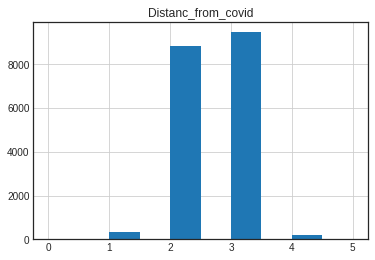

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

y1 = np.random.normal(1, 2, 5000)
y = np.random.normal(-1, 3, 2000)
bins = np.linspace(-10, 10, 30)

plt.hist([x, y], bins, label=['x', 'y'])
plt.legend(loc='upper right')
plt.show()

In [ ]:
g1 = g.copy()
g1.add_node('covid')
g1.add_edges_from([('covid', source) for source in interactions.entrezgene])
length = nx.single_source_shortest_path_length(g1, 'covid')

In [ ]:
all_distances = pd.DataFrame(list(length.items()),columns = ['Protien','Distanc_from_covid'])
all_distances.to_csv(f'covid_files/4_Distance_from_covid/4.1_all_protiens.csv', index=False)

(array([1.06123315e-04, 0.00000000e+00, 3.53390640e-02, 0.00000000e+00,
        9.35901518e-01, 0.00000000e+00, 1.00520004e+00, 0.00000000e+00,
        2.30287594e-02, 4.24493261e-04]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

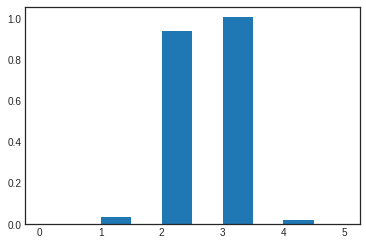

In [ ]:
plt.hist(length.values(), density=True, bins=10)

In [ ]:
# calculate p_value by target 
for dataset, target in all_targets.items():
  rows = []
  for target_name, id in target.items():
    if length.get(id):
      rows.append([target_name, id, length[id]-1])
  temp_data = pd.DataFrame(rows, columns=["gene", "entrez", "distance"])
  temp_data.to_csv(f'covid_files/4_Distance_from_covid/4.1_{dataset}_distance.csv', index=False)

In [ ]:
average = {}
for viral in interactions['viral'].unique():
  g2 = g.copy()
  g2.add_node(viral)
  g2.add_edges_from([(viral, source) for source in interactions[interactions['viral']==viral].entrezgene])
  length = nx.single_source_shortest_path_length(g2, viral)
  rows = []
  for dataset, target in all_targets.items():
    for target_name, id in target.items():
      if length.get(id):
        rows.append([target_name, id, length[id]-1])
  temp_data = pd.DataFrame(rows, columns=["gene", "entrez", "distance"])
  temp_data.to_csv(f'covid_files/4_Distance_from_covid/by_source/4.2_distance_from_{viral}.csv', index=False)
  average[viral] = round(np.average(temp_data['distance']),0)  

In [ ]:
for viral in interactions['viral'].unique():
  g2 = g.copy()
  g2.add_node(viral)
  g2.add_edges_from([(viral, source) for source in interactions[interactions['viral']==viral].entrezgene])
  length = nx.single_source_shortest_path_length(g2, viral)
  rows = []
  for dataset, target in all_targets.items():
    if dataset == 'vascular':
      for target_name, id in target.items():
        if length.get(id):
          rows.append([target_name, id, length[id]-1])
  temp_data = pd.DataFrame(rows, columns=["gene", "entrez", "distance"])
  temp_data.to_csv(f'covid_files/4_Distance_from_covid/by_source_vascular/4.3_distance_from_{viral}.csv', index=False)

### distribution compare

In [ ]:
all_protiens = []
for k,v in all_targets.items():
  all_protiens += list(v.values()) 

In [ ]:
all = []
for i in range(100):
  random_source = random.sample(population=list(g.nodes), k=len(interactions.entrezgene))
  g1 = g.copy()
  g1.add_node('random')
  g1.add_edges_from([('random', source) for source in random_source])
  random_dist = nx.single_source_shortest_path_length(g1, 'random')
  distances = []
  for k,v in random_dist.items():
    if k in all_protiens:
      distances.append(v)
  all.append(distances)

In [ ]:
a = np.array(all)
average_random = np.mean(a, axis=0)

In [ ]:
g1 = g.copy()
g1.add_node('covid')
g1.add_edges_from([('covid', source) for source in interactions.entrezgene.tolist()])
covid_distance = nx.single_source_shortest_path_length(g1, 'covid')
covid_distance.pop('covid')

0

In [ ]:
covid_dist = []
for k,v in covid_distance.items():
  # print(type(k))
  if isinstance(k,int):
    if k in all_protiens:
      covid_dist.append(v)

(array([2.75862069, 0.        , 0.        , 0.        , 0.        ,
        2.19827586, 0.        , 0.        , 0.        , 0.04310345]),
 array([2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 <a list of 10 Patch objects>)

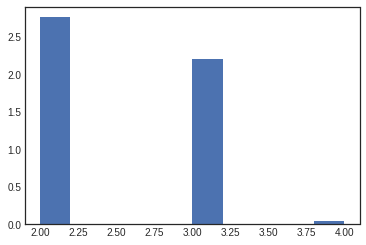

In [ ]:
plt.hist(covid_dist, density=True)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



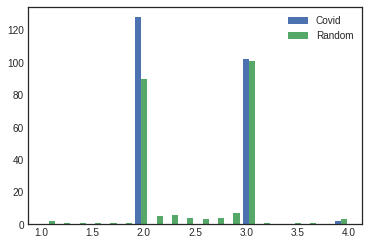

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
plt.hist([covid_dist, average_random], label=['Covid', 'Random'], bins=20)
plt.legend(loc='upper right')
plt.savefig('covid_files/4_Distance_from_covid/distribution.png')
plt.show()

In [ ]:
E = g.number_of_edges()
Q = 10
random_distances = {}
for i in range(100):
    H = g.copy()
    nx.swap.double_edge_swap(H, nswap=Q*E, max_tries=Q*E*2) 
    H.add_node('covid') 
    H.add_edges_from([('covid', source) for source in interactions.entrezgene.tolist()])
    for dataset, v in all_targets.items():
      H.add_node(dataset)
      H.add_edges_from([(dataset, target) for target in list(v.values())])
    distances = nx.single_source_shortest_path_length(H, 'covid')
    random_distances[i] = distances
joblib.dump(random_distances, 'covid_files/4_Distance_from_covid/random_distances.pkl.gz')

In [ ]:
joblib.dump(random_distances, 'covid_files/4_Distance_from_covid/random_distances.pkl.gz')

['covid_files/4_Distance_from_covid/random_distances.pkl.gz']

In [ ]:
p_values = {}
for dataset, v in all_targets.items():
  runs = []
  g1 = g.copy()
  g1.add_node('covid')
  g1.add_node(dataset)
  g1.add_edges_from([('covid', source) for source in interactions.entrezgene.tolist()])
  g1.add_edges_from([(dataset, target) for target in list(v.values())])
  covid_distance = nx.single_source_shortest_path_length(g1, 'covid')
  runs.append(covid_distance[dataset])
  for k,v in random_distances.items():
    runs.append(v[dataset])
  pvalue = (92 - sp.stats.rankdata(runs, method="ordinal")[0]) / 91
  p_values[dataset] = {'p_value':pvalue, 'distance':runs[0]}

In [ ]:
for i in range(90): 
  print(random_distances[i]['bronchial'])

In [ ]:
E = g.number_of_edges()
Q = 10
p_values = {}
for dataset, v in all_targets.items():
  runs = []
  g1 = g.copy()
  g1.add_node('covid')
  g1.add_node(dataset)
  g1.add_edges_from([('covid', source) for source in interactions.entrezgene.tolist()])
  g1.add_edges_from([(dataset, target) for target in list(v.values())])
  covid_distance = nx.single_source_shortest_path_length(g1, 'covid')
  runs.append(covid_distance[dataset])
  
  for i in range(100):
    H = g.copy()
    nx.swap.double_edge_swap(H, nswap=Q*E, max_tries=Q*E*2) 
    H.add_node('covid') 
    H.add_node(dataset)
    H.add_edges_from([('covid', source) for source in interactions.entrezgene.tolist()])
    H.add_edges_from([(dataset, target) for target in list(v.values())])
    random = nx.single_source_shortest_path_length(H, 'covid')
    runs.append(random[dataset])
  pvalue = (102 - sp.stats.rankdata(runs, method="ordinal")[0]) / 101
  p_values[dataset] = {'p_value':pvalue, 'distance':runs[0]}

In [ ]:
p_values

## 5 Significant Interactions

### 5.1

In [ ]:
# all_data = pd.read_csv(f'outputs/p_value_by_target/vacular_p_values.csv')
all_data = ongoing_data
for dataset, target in all_targets.items():
  temp_data = pd.read_csv(f'covid_files/3_random_networks/3.2_{dataset}_p_values.csv')
  all_data = pd.concat([all_data, temp_data], axis=1, join='inner').T.drop_duplicates().T
all_data.to_csv(f'covid_files/5_significant_interactions/5.1_all_data_p_values.csv', index=False)

### 5.2

In [ ]:
all_data_pv = pd.read_csv(f'covid_files/5_significant_interactions/5.1_all_data_p_values.csv')
significant_viral_for_each_target_pv = {}
for columnName, columnData in all_data_pv.iteritems():
  if columnName not in('viral','Preys'):
    sig_virals = all_data_pv[all_data_pv[columnName]<0.05]['viral']
    significant_viral_for_each_target_pv[columnName] = list(sig_virals.values)  

with open('covid_files/5_significant_interactions/5.2_significant_viral_for_each_target_pv.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in significant_viral_for_each_target_pv.items():
       writer.writerow([key, value])

### 5.3


In [ ]:
all_data_pv = pd.read_csv(f'covid_files/5_significant_interactions/5.1_all_data_p_values.csv').set_index('viral').T.reset_index()
significant_target_for_each_viral_pv = {}
for columnName, columnData in all_data_pv.iteritems():
  if columnName not in('viral','index'):
    sig_virals = all_data_pv[all_data_pv[columnName]<0.05]['index']
    significant_target_for_each_viral_pv[columnName] = list(sig_virals.values)  

with open('covid_files/5_significant_interactions/5.3_significant_target_for_each_viral_pv.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in significant_target_for_each_viral_pv.items():
       writer.writerow([key, value])

### 5.4

In [ ]:
import scipy.stats as st
from statsmodels.stats.multitest import local_fdr

for dataset, target in all_targets.items():
  temp_data = pd.read_csv(f'covid_files/3_random_networks/3.2_{dataset}_p_values.csv')
  cells = temp_data.columns.to_list()[2:]
  effects = temp_data[[i for i in cells]].to_numpy()
  shape = effects.shape
  # p_values = [i if i<1 else (i-np.finfo(float).eps) for i in effects.flatten()]
  # zscores = st.norm.ppf(p_values) 
  # adj_pvalue = local_fdr(zscores, null_proportion=0.1).reshape(shape)

  adj_pvalue = sm.stats.multipletests(effects.flatten(), method="fdr_bh", is_sorted=False)[1].reshape(shape)
  temp_data[[i for i in cells]] = adj_pvalue
  temp_data.to_csv(f'covid_files/5_significant_interactions/5.4_{dataset}_adj_p_values.csv', index=False)

### 5.5

In [ ]:
all_data = ongoing_data
for dataset, target in all_targets.items():
  temp_data = pd.read_csv(f'covid_files/5_significant_interactions/5.4_{dataset}_adj_p_values.csv')
  all_data = pd.concat([all_data, temp_data], axis=1, join='inner').T.drop_duplicates().T
all_data.to_csv(f'covid_files/5_significant_interactions/5.5_all_data_adj_p_values.csv', index=False)

### 5.6


In [ ]:
all_data_pv = pd.read_csv(f'covid_files/5_significant_interactions/5.5_all_data_adj_p_values.csv')
significant_viral_for_each_target_pv = {}
for columnName, columnData in all_data_pv.iteritems():
  if columnName not in('viral','Preys'):
    sig_virals = all_data_pv[all_data_pv[columnName]<0.22]['viral']
    significant_viral_for_each_target_pv[columnName] = list(sig_virals.values)  

with open('covid_files/5_significant_interactions/5.6_significant_viral_for_each_target_adjusted.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in significant_viral_for_each_target_pv.items():
       writer.writerow([key, value])

### 5.7

In [ ]:
all_data_pv = pd.read_csv(f'covid_files/5_significant_interactions/5.5all_data_adj_p_values.csv').set_index('viral').T.reset_index()
significant_target_for_each_viral_pv = {}
for columnName, columnData in all_data_pv.iteritems():
  if columnName not in('viral','index'):
    sig_virals = all_data_pv[all_data_pv[columnName]<0.22]['index']
    significant_target_for_each_viral_pv[columnName] = list(sig_virals.values)  

with open('covid_files/5_significant_interactions/5.7_significant_target_for_each_viral_adjusted.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in significant_target_for_each_viral_pv.items():
       writer.writerow([key, value])

## 6 Empirical Adjusted P-Value

In [ ]:
# combine all datasets
targets = {}
for key, value in all_targets.items():
  targets.update(value)

In [ ]:
max_per_network = {}
for network_id, net_scores in random_networks.items():
  max_score = 0
  for target_name, id in targets.items():
    if gene_indexes.get(id):
      tar_id = gene_indexes[id]
      for index, row in ongoing_data.iterrows():
        sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
        score = sum(net_scores[s][tar_id] for s in sources)
        if score > max_score: 
          max_score = score
  max_per_network[network_id] = max_score

In [ ]:
# calculate p_value by target 
for dataset, target in all_targets.items():
  temp_data = ongoing_data.copy()
  for target_name, id in target.items():
    viral_p_values = []
    if gene_indexes.get(id):
      tar_id = gene_indexes[id]
      for index, row in ongoing_data.iterrows():
          runs = list(max_per_network.values()).copy()
          # calculate the score of viral gene
          sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
          score = sum(gene_scores[s][tar_id] for s in sources)
          runs.append(score)
          # runs.append(list(max_per_network.values()))

          pvalue = (102 - sp.stats.rankdata(runs, method="ordinal")[100]) / 101
          viral_p_values.append(pvalue)

      temp_data[target_name] = viral_p_values + np.finfo(float).eps
  temp_data.to_csv(f'outputs/adjusted_pvalues/{dataset}_adj_p_values.csv', index=False)

In [ ]:
all_data = ongoing_data
for dataset, target in all_targets.items():
  temp_data = pd.read_csv(f'outputs/adjusted_pvalues/{dataset}_adj_p_values.csv')
  all_data = pd.concat([all_data, temp_data], axis=1, join='inner').T.drop_duplicates().T
all_data.to_csv(f'outputs/top_interactions/all_data_adj_p_values.csv', index=False)

In [ ]:
all_data_pv = pd.read_csv(f'outputs/top_interactions/all_data_p_values.csv')
significant_viral_for_each_target_pv = {}
for columnName, columnData in all_data_pv.iteritems():
  if columnName not in('viral','Preys'):
    sig_virals = all_data_pv[all_data_pv[columnName]<0.05]['viral']
    significant_viral_for_each_target_pv[columnName] = list(sig_virals.values)  

with open('outputs/top_interactions/significant_viral_for_each_target_pv.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in significant_viral_for_each_target_pv.items():
       writer.writerow([key, value])

In [ ]:
all_data_pv = pd.read_csv(f'outputs/top_interactions/all_data_p_values.csv').set_index('viral').T.reset_index()
significant_target_for_each_viral_pv = {}
for columnName, columnData in all_data_pv.iteritems():
  if columnName not in('viral','index'):
    sig_virals = all_data_pv[all_data_pv[columnName]<0.05]['index']
    significant_target_for_each_viral_pv[columnName] = list(sig_virals.values)  

with open('outputs/top_interactions/significant_target_for_each_viral_pv.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in significant_target_for_each_viral_pv.items():
       writer.writerow([key, value])

## per viral PV

In [ ]:
# combine all datasets
targets = {}
for key, value in all_targets.items():
  targets.update(value)

In [ ]:
max_per_viral = {}
for index, row in ongoing_data.iterrows():
    sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
    max_networks = []
    for network_id, net_scores in random_networks.items():
      max_score = 0
      for target_name, id in targets.items():
        if gene_indexes.get(id):
          tar_id = gene_indexes[id]
          score = sum(net_scores[s][tar_id] for s in sources)
          if score > max_score: 
            max_score = score
      max_networks.append(max_score)
    max_per_viral[row["viral"]] = max_networks

In [ ]:
# calculate p_value by target 
for dataset, target in all_targets.items():
  temp_data = ongoing_data.copy()
  for target_name, id in target.items():
    viral_p_values = []
    if gene_indexes.get(id):
      tar_id = gene_indexes[id]
      for index, row in ongoing_data.iterrows():
          runs = max_per_viral[row["viral"]]
          # calculate the score of viral gene
          sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
          score = sum(gene_scores[s][tar_id] for s in sources)
          runs.append(score)
          # runs.append(list(max_per_network.values()))

          pvalue = (102 - sp.stats.rankdata(runs, method="ordinal")[100]) / 101
          viral_p_values.append(pvalue)

      temp_data[target_name] = viral_p_values + np.finfo(float).eps
  temp_data.to_csv(f'outputs/adjusted_pvalues/{dataset}_adj_p_values.csv', index=False)

In [ ]:
from statsmodels.stats.multitest import local_fdr
import numpy as np
zscores = np.random.randn(30)
fdr = local_fdr(zscores)

# 1.Correlation


In [ ]:
target_vas = list(all_targets['vascular'].values())
target_index = [gene_indexes[i] for i in target_vas if i in gene_indexes]

In [ ]:
perm3 = pd.read_csv("covid_files/data/inputs/perm3.csv")  # permeability after 3 Days
perm4 = pd.read_csv("covid_files/data/inputs/perm4.csv")  # permeability after 4 Days
# grouping count
interaction_count = interactions.groupby("viral", as_index=False).count()
interaction_count["viral"] = interaction_count.apply(lambda row: row["viral"].lower(), axis=1)

# %%
# lower case the protiens names
perm3["Viral Protein SARS-Cov-2"] = perm3.apply(lambda row: row["Viral Protein SARS-Cov-2"].lower(), axis=1)
perm4["Viral Protein SARS-Cov-2"] = perm4.apply(lambda row: row["Viral Protein SARS-Cov-2"].lower(), axis=1)

# join permeabilty and interactions
corr_data = interaction_count.merge(perm3, left_on="viral", right_on="Viral Protein SARS-Cov-2")
corr_data = corr_data.merge(perm4, left_on="viral", right_on="Viral Protein SARS-Cov-2")

ongoing_data = pd.DataFrame(columns=['viral', 'interactions_count', 'perm_3_days'])
ongoing_data['viral'] = corr_data['viral']
ongoing_data['interactions_count'] = corr_data['Preys']
ongoing_data['perm_3_days'] = corr_data['Permeability Value (3 days)']
ongoing_data['perm_4_days'] = corr_data['Permeability Value (4 days)']
del(corr_data)

In [ ]:
temp_data = ongoing_data.copy()
interactions = interactions.dropna()
# calculate p-value and scores multi-Nets
viral_p_values = []
for index, row in ongoing_data.iterrows():
    runs = []
    # calculate the score of viral gene
    sources = interactions[interactions["viral"].str.lower() == row["viral"]]["entrezgene"].to_list()
    score = sum([sum(v[target_index]) for k, v in gene_scores.items() if k in sources])
    runs.append(score)

    # generate 100 random scores by 100 random networks
    for net, prop in random_networks.items():
        score = sum([sum(v[target_index]) for k, v in prop.items() if k in sources])
        runs.append(score)

    pvalue = (102 - sp.stats.rankdata(runs, method="ordinal")[0]) / 101
    viral_p_values.append(pvalue)

temp_data["pvalue_multi_net"] = viral_p_values
temp_data["adjusted_pvalue_multi_net"] = sm.stats.multipletests(temp_data["pvalue_multi_net"], alpha=0.05, method="fdr_bh", is_sorted=False)[1]
temp_data.to_csv('covid_files/1_perm_correlation/1.3_data.csv',index=False)

In [ ]:
data = pd.read_csv('covid_files/1_perm_correlation/1.3_data.csv')
# correlation of number of adj-pvalue random networks
correlation_5 = round(sp.stats.pearsonr(data["adjusted_pvalue_multi_net"], data["perm_3_days"])[0], 4)
fig = px.scatter(data, x="adjusted_pvalue_multi_net", y="perm_3_days", text="viral")
fig.update_traces(textposition="top center")
fig.update_layout(height=800, title_text=f"""Adjusted P-value(multi-net) Vs Permeability, Pearson={correlation_5}""")
fig.write_html('covid_files/1_perm_correlation/1.3.html')
fig.show()